## Implement RandomSearchCV with k fold cross validation on KNN

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from itertools import permutations
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

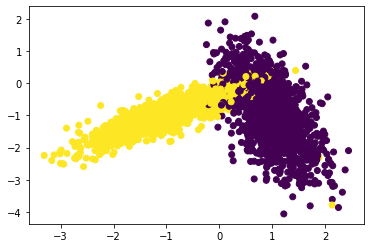

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [4]:
def RandomSearchCV(X_train,y_train,classifier, param_range, folds=3):
    trainscores = []
    testscores  = [] 
    #Setting up different random values of hyperparameters
    params = {'n_neighbors':sorted(list(set(random.sample(range(param_range[0], param_range[1]), 10))))}
    
    #Initializing empty lists to store data chunks and respective class labels
    data_folds = []
    data_folds_labels = []
    
    #Splitting data into k-folds data chunks
    a=0
    b = int(len(X_train)/folds)
    for i in range(1, folds+1):
        chunk = range(a, b*i)
        data_chunk = X_train[chunk]
        data_chunk_labels = y_train[chunk]
        data_folds.append(data_chunk)
        data_folds_labels.append(data_chunk_labels)
        a = b*i+1
        
    all_combinations = []
    perm = permutations(range(int(folds)), int(folds))
    for i in perm:
        all_combinations.append(list(i))

    result = []
    for ele in all_combinations:
        i = len(ele)
        intrim_ele = [ele[:-1]]
        intrim_ele.append(ele[-1])
        result.append(intrim_ele)

    trial = []
    for ele in result:
        a = [sorted(ele[0]), ele[1]]
        trial.append(a)
    
    #retaining only unique combinations
    result_ = [] 
    [result_.append(x) for x in trial if x not in result_]
    #print(res)  will give [[[0, 1], 2], [[0, 2], 1], [[1, 2], 0]] 
    #will use this to create various combinations of data chunks

    #Initializing list to store K-fold train data
    final_train = []
    final_train_labels = []
    #Similarly Initializing lists for K-fold CV data
    final_CV = []
    final_CV_labels = []

    #Creating single fold
    for ele in result_:
        train_data = []
        train_labels = []
        CV_data = []
        CV_labels = []
        for i in range(len(ele[0])):
            train_data.append(data_folds[ele[0][i]])
            train_labels.append(data_folds_labels[ele[0][i]])
        final_train.append(train_data)
        final_train_labels.append(train_labels)
    
        CV_data.append(data_folds[ele[1]])
        CV_labels.append(data_folds_labels[ele[1]])
        final_CV.append(CV_data)
        final_CV_labels.append(CV_labels)
    
    for k in tqdm(params['n_neighbors']):
        trainscores_folds = []
        testscores_folds  = []
        for j in range(0, folds):
            
            #train_extract  = final_train[j]
            #Joining 2 chunks as a train data and rest as a CV data
            train_kfold = np.concatenate([arr for arr in final_train[j]])
            train_kfold_labels = np.concatenate([arr_labels for arr_labels in final_train_labels[j]])                                         
            cv_kfold  = final_CV[j]
            cv_kfold_labels = final_CV_labels[j]
            
            classifier.n_neighbors = k
            classifier.fit(train_kfold,train_kfold_labels)

            CV_predicted = classifier.predict(*cv_kfold)
            testscores_folds.append(accuracy_score(*cv_kfold_labels, CV_predicted))

            Y_predicted = classifier.predict(train_kfold)
            trainscores_folds.append(accuracy_score(train_kfold_labels, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores, testscores, params, final_train

In [5]:
folds  = 7
param_range = (1, 50)
neigh = KNeighborsClassifier()

In [6]:
trainscores, testscores, params, final_train = RandomSearchCV(X_train,y_train, neigh, param_range, folds)

100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Number of Folds 7


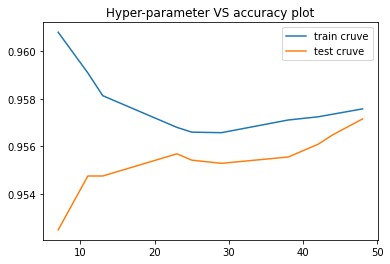

In [7]:
#CODE REFERENCE: Assignment_4_Reference notebook by AAIC
print("Number of Folds", len(final_train))
plt.plot(params['n_neighbors'],trainscores, label='train cruve')
plt.plot(params['n_neighbors'],testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [8]:
#CODE REFERENCE: Assignment_4_Reference notebook by AAIC
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

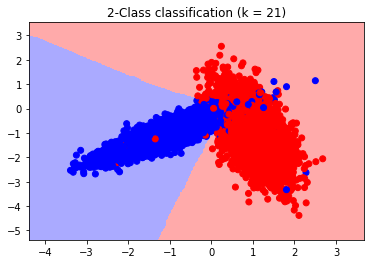

In [9]:
#CODE REFERENCE: Assignment_4_Reference notebook by AAIC
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

_______